In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import scipy as sc
from pyBKT.models import Model

# Tensorflow
import tensorflow as tf

%matplotlib inline

# Get rid of some "wrong" errors
# check https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas for why 
pd.options.mode.chained_assignment = None  # default='warn'

2023-06-09 20:01:59.362254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-09 20:01:59.362364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
events = pd.read_csv('data/calcularis_small_events.csv', encoding='latin', low_memory=False)
subtasks = pd.read_csv('data/calcularis_small_subtasks.csv', encoding='latin', low_memory=False)
users = pd.read_csv('data/calcularis_small_users.csv', encoding='latin', low_memory=False)

In [3]:
events.head(15)

,event_id,user_id,mode,game_name,learning_time_ms,number_range,start,end,skill_id,type
0,0,1,NORMAL,Subitizing,"8,835.00000",R10,2022-11-02T08:39:12.355Z,2022-11-02T08:39:25.130Z,1.00000,task
1,1,1,NORMAL,Conversion,"21,167.00000",R10,2022-11-11T10:26:27.893Z,2022-11-11T10:26:49.260Z,4.00000,task
2,2,1,NORMAL,Conversion,"11,182.00000",R10,2022-11-18T10:34:01.044Z,2022-11-18T10:34:12.423Z,7.00000,task
3,3,1,NORMAL,Landing,"6,823.00000",R10,2022-11-25T10:32:43.428Z,2022-11-25T10:32:56.986Z,19.00000,task
4,4,1,END_OF_NR,Conversion,"9,107.00000",R10,2022-12-02T10:44:40.555Z,2022-12-02T10:44:49.874Z,7.00000,task
5,5,1,END_OF_NR,Conversion,"10,703.00000",R10,2022-12-09T10:12:16.068Z,2022-12-09T10:12:26.984Z,4.00000,task
6,6,1,NORMAL,Comparison,"1,383.00000",R20,2022-12-16T10:25:42.441Z,2022-12-16T10:25:45.508Z,33.00000,task
7,7,1,END_OF_NR,Landing,"6,052.00000",R20,2023-01-20T10:13:41.496Z,2023-01-20T10:13:49.096Z,50.00000,task
8,8,1,END_OF_NR,Landing,"6,055.00000",R20,2023-01-27T10:18:17.427Z,2023-01-27T10:18:26.356Z,49.00000,task
9,9,1,END_OF_NR,Estimation on Number Line,"10,541.00000",R20,2023-02-03T10:20:25.581Z,2023-02-03T10:20:38.687Z,39.00000,task


In [4]:
subtasks.head(15)

,subtask_id,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,...,startPosition,subtask_finished_timestamp,target,timeoutInSeconds,timeoutInSteps,type,upperBound,divisor,orderIndependent,step
0,0,0,1,NaN,4,NaN,NaN,True,4,4.00000,...,NaN,2022-11-02T08:39:24.930Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN
1,1,0,1,NaN,1,NaN,NaN,True,NaN,NaN,...,NaN,2022-11-02T08:39:24.930Z,NaN,0.00000,2.00000,ConciseTimeoutDescription,NaN,NaN,NaN,NaN
2,2,1,1,NaN,3,NaN,NaN,True,3,NaN,...,NaN,2022-11-11T10:26:49.007Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN
3,3,2,1,NaN,5,NaN,NaN,True,5,NaN,...,NaN,2022-11-18T10:34:12.191Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN
4,4,3,1,3.00000,"{'a': 2, 'b': 2.0402703}",NaN,NaN,False,"{'a': 3, 'b': 3.0}",NaN,...,0.50000,2022-11-25T10:32:56.805Z,NaN,NaN,NaN,ConciseLandingTaskDescription,3.50000,NaN,NaN,NaN
5,5,4,1,NaN,9,NaN,NaN,True,9,NaN,...,NaN,2022-12-02T10:44:49.621Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN
6,6,5,1,NaN,7,NaN,NaN,False,9,NaN,...,NaN,2022-12-09T10:12:26.729Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN
7,7,6,1,NaN,16,NaN,NaN,True,16,NaN,...,NaN,2022-12-16T10:25:45.293Z,NaN,NaN,NaN,ConciseSetComparisonTaskDescription,NaN,NaN,NaN,NaN
8,8,6,1,NaN,1.3659,NaN,NaN,True,NaN,NaN,...,NaN,2022-12-16T10:25:45.293Z,NaN,4.00000,0.00000,ConciseTimeoutDescription,NaN,NaN,NaN,NaN
9,9,7,1,4.00000,"{'a': 4, 'b': 4.148817}",NaN,NaN,True,"{'a': 4, 'b': 4.0}",NaN,...,0.50000,2023-01-20T10:13:48.879Z,NaN,NaN,NaN,ConciseLandingTaskDescription,5.00000,NaN,NaN,NaN


In [5]:
users.head(15)

,user_id,learning_time_ms,start,end,logged_in_time_ms,language,country
0,1,14032710,2022-11-02T08:37:56.549Z,2023-02-09T11:08:02.599Z,22151340,de,CH
1,2,16268350,2022-09-07T07:53:38.865Z,2023-02-09T08:39:14.692Z,85421273,nl,NL
2,3,8012030,2021-09-27T07:45:51.806Z,2022-01-13T12:14:09.565Z,16651482,de,DE
3,4,1414421,2019-11-12T12:18:15.724Z,2020-10-02T09:20:28.798Z,4561768,de,CH
4,5,17502108,2022-04-26T11:38:44.114Z,2022-08-29T15:52:11.087Z,25601470,de,CH
5,6,8353125,2022-09-02T07:27:20.675Z,2023-02-01T10:35:15.218Z,19249399,nl,NL
6,7,7226229,2015-03-19T18:47:32.621Z,2015-05-29T18:17:32.889Z,9225357,NaN,NaN
7,8,64629753,2021-08-23T09:04:32.478Z,2022-06-20T12:13:06.081Z,125236245,de,CH
8,9,7647781,2019-08-20T17:02:06.155Z,2020-03-08T14:08:06.321Z,9089877,de,DE
9,10,22569161,2017-08-30T06:27:19.365Z,2021-07-08T14:09:17.450Z,33642991,de,NaN


In [6]:
# extract game_name and number_range from the events dataframe to match the subtasks dataframe (given the event_id)
game_name = subtasks.merge(events[['event_id', 'game_name']], on='event_id', how='left').game_name
number_range = subtasks.merge(events[['event_id', 'number_range']], on='event_id', how='left').number_range

#split the game_name into skills
skill = game_name.apply(lambda x: 'Number representation' 
                        if x in ['Subitizing', 'Conversion', 'Estimation', 'Estimation on Number Line', 'Scale: Conversion', 'Landing'] 
                        else 'Number comparison/manipulation' if x in ['Comparison', 'Secret Number', 'Distance', 'Scale: Composition', 'Order'] 
                        else 'Addition/Substraction' if x in ['Scale: Decomposition', 'Scale: Subtraction', 'Scale: Subtraction by Tens and Ones', 'Sliderule', 'Plus-minus', 'Difference', 'Completion', 'Calculator'] 
                        else 'Multiplication/Division' if x in ['Write as multiplication', 'Shelf: Jump Ahead', 'Shelf: given height', 'Shelf: random height', 'Distribution', 'Calculator: Multiplication', 'Calculator: Multiplication with ?', 'Calculator: Division', 'Jump backwards', 'Series'] 
                        else 'Other')

# concatenate skills and number range and add it to the subtasks dataframe
subtasks['skill_name'] = skill + ' ' + number_range
subtasks

,subtask_id,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,...,subtask_finished_timestamp,target,timeoutInSeconds,timeoutInSteps,type,upperBound,divisor,orderIndependent,step,skill_name
0,0,0,1,NaN,4,NaN,NaN,True,4,4.00000,...,2022-11-02T08:39:24.930Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
1,1,0,1,NaN,1,NaN,NaN,True,NaN,NaN,...,2022-11-02T08:39:24.930Z,NaN,0.00000,2.00000,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10
2,2,1,1,NaN,3,NaN,NaN,True,3,NaN,...,2022-11-11T10:26:49.007Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
3,3,2,1,NaN,5,NaN,NaN,True,5,NaN,...,2022-11-18T10:34:12.191Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
4,4,3,1,3.00000,"{'a': 2, 'b': 2.0402703}",NaN,NaN,False,"{'a': 3, 'b': 3.0}",NaN,...,2022-11-25T10:32:56.805Z,NaN,NaN,NaN,ConciseLandingTaskDescription,3.50000,NaN,NaN,NaN,Number representation R10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55042,55042,37415,998,46.00000,"{'a': 47, 'b': 47.33128}",NaN,NaN,True,"{'a': 46, 'b': 46.0}",NaN,...,2021-01-06T14:14:46.133Z,NaN,NaN,NaN,ConciseLandingTaskDescription,50.00000,NaN,NaN,NaN,Number representation R100
55043,55043,37417,1000,NaN,1,NaN,NaN,False,3,3.00000,...,2019-09-30T10:04:58.024Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
55044,55044,37417,1000,NaN,2,NaN,NaN,True,NaN,NaN,...,2019-09-30T10:04:58.024Z,NaN,0.00000,2.00000,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10
55045,55045,37418,1000,NaN,3,NaN,NaN,True,3,NaN,...,2020-01-20T10:03:51.556Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10


# DKT model

In [7]:
from sklearn import feature_extraction, model_selection
from sklearn.model_selection import train_test_split

In [8]:
# Useful functions for what comes next
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(X, groups=groups)

def prepare_seq(df):
    # Step 1 - Enumerate skill id, each different skill has a different id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)
    # Step 2 - Cross skill id with answer to form a synthetic feature, being 2*skill_id + correct, which is 1 if subtask was correct, 0 else 
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']
    # Step 3 - Convert to a sequence per user id and shift features 1 timestep, take all skill_with_answer except last value, take all skill and correct values except first
    #old version  :seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values, r['skill'].values, r['correct'].values,))
    
    # Step 4 - Get max skill depth and max feature depth
    skill_depth = df['skill'].max()+1
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth, skill_codes

def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Transform sequence to Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))
    
    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=False
    )
    return dataset.repeat(), len(seq)

### Split data in train and test sets

In [9]:
# Obtain indexes
train_index, test_index = next(create_iterator(subtasks))
# Split the data
X_train, X_test = subtasks.iloc[train_index], subtasks.iloc[test_index]

# Split train data in train and validation sets
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

### Data preparation

In [10]:
# Specify parameters
params = {}
params['batch_size'] = 20
params['mask_value'] = -1.0

In [11]:
# Prepare the data
seq, features_depth, skill_depth, skill_codes = prepare_seq(subtasks)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

# Specify further params
params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

2023-06-09 20:02:23.192914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-09 20:02:23.193003: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-09 20:02:23.193087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noto.epfl.ch): /proc/driver/nvidia/version does not exist
2023-06-09 20:02:23.230590: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model creation

In [12]:
# Define model parameters
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [13]:
# Function that removes predictions on time step associated with padding, and match outputs to specific skills
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [14]:
# Define the metrics
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

In [15]:
# Model creation 
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'], name = 'masking')(inputs)
    x = tf.keras.layers.LSTM(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'], name = 'lstm_layer')(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [16]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 32)]        0         
                                                                 
 masking (Masking)           (None, None, 32)          0         
                                                                 
 lstm_layer (LSTM)           (None, None, 16)          3136      
                                                                 
 outputs (TimeDistributed)   (None, None, 16)          272       
                                                                 
Total params: 3,408
Trainable params: 3,408
Non-trainable params: 0
_________________________________________________________________


### Model fitting and evaluation

In [17]:
# Model fit
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'],
                    validation_data=tf_val,  validation_steps = params['val_size'],
                    callbacks=[ckp_callback], verbose=params['verbose'])

# Model evaluation
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

Epoch 1/10
37/37 [==============================] - 31s 649ms/step - loss: 0.1645 - auc: 0.6768 - root_mean_squared_error: 0.4789 - val_loss: 0.1512 - val_auc: 0.7627 - val_root_mean_squared_error: 0.4533
Epoch 2/10
37/37 [==============================] - 22s 598ms/step - loss: 0.1407 - auc: 0.7384 - root_mean_squared_error: 0.4297 - val_loss: 0.1248 - val_auc: 0.7393 - val_root_mean_squared_error: 0.3980
Epoch 3/10
37/37 [==============================] - 22s 595ms/step - loss: 0.1187 - auc: 0.7331 - root_mean_squared_error: 0.3846 - val_loss: 0.1105 - val_auc: 0.7639 - val_root_mean_squared_error: 0.3708
Epoch 4/10
37/37 [==============================] - 21s 575ms/step - loss: 0.1085 - auc: 0.7753 - root_mean_squared_error: 0.3650 - val_loss: 0.1024 - val_auc: 0.8062 - val_root_mean_squared_error: 0.3548
Epoch 5/10
37/37 [==============================] - 24s 644ms/step - loss: 0.1015 - auc: 0.8175 - root_mean_squared_error: 0.3509 - val_loss: 0.0957 - val_auc: 0.8528 - val_root_me

In [18]:
# Getting the metrics
# Binary cross entropy, AUC, RMSE
print(metrics_dkt_small)
rmse_dkt = metrics_dkt_small[2]
auc_dkt = metrics_dkt_small[1]

[0.06259084492921829, 0.9861854314804077, 0.24981427192687988]


# BKT model

In [19]:
# Initialize and fit BKT on the same train set as DKT
model = Model(seed=0, defaults={'order_id' : 'subtask_id'})
%time model.fit(data=X_train, forgets = True)
#preds = model.predict(data=X_test_skill)[['subtask_id','user_id', 'skill_name', 'correct']]
auc_bkt = model.evaluate(data=X_test, metric='auc')
rmse_bkt = model.evaluate(data=X_test, metric='rmse')

CPU times: user 7.09 s, sys: 0 ns, total: 7.09 s
Wall time: 3.62 s


# Comparison between BKT and DKT on the test set

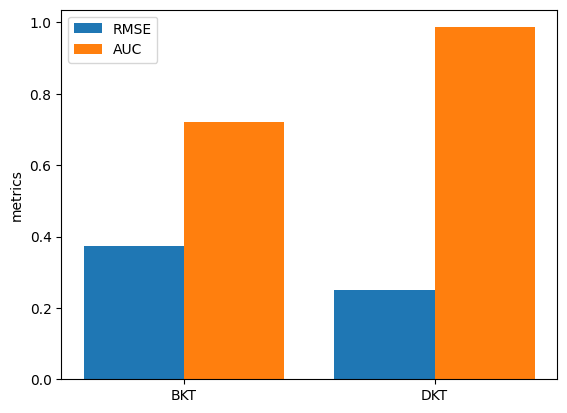

In [20]:
#Visualize plot
rmse = [rmse_bkt, rmse_dkt]
models = ['BKT','DKT']
X_ticks = np.arange(len(models))

plt.bar(X_ticks - 0.2, rmse, 0.4, label='RMSE')

auc = [auc_bkt, auc_dkt]

plt.bar(X_ticks + 0.2, auc, 0.4, label='AUC')
plt.xticks(X_ticks, models)
plt.ylabel('metrics')
plt.legend()

We observe that DKT outperforms BKT in termns of both AUC and RMSE